In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.utils import shuffle
import keras

df_csv = pd.read_csv("../input/creditcard.csv")
df_csv.head()

Using TensorFlow backend.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
df_norm = (df_csv - df_csv.min() ) / (df_csv.max() - df_csv.min() )
df_norm.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,0.252484,0.680908,0.371591,0.635591,0.446084,0.434392,0.737173,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0.0
1,0.000000,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,0.381188,0.744342,0.486190,0.641219,0.383840,0.464105,0.727794,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0.0
2,0.000006,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,0.322422,0.706683,0.503854,0.640473,0.511697,0.357443,0.763381,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0.0
3,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,0.271817,0.710910,0.487635,0.636372,0.289124,0.415653,0.711253,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0.0
4,0.000012,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,0.236355,0.724477,0.552509,0.608406,0.349419,0.434995,0.724243,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0.0


In [3]:
# 전체거래건/사기건 비율
ratio = len(df_norm)/len(df_norm[df_norm.Class!=0.0]) 
df_norm.loc[:,'Class'] *= ratio
df_norm[df_norm.Class!=0.0][:3]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,0.002350,0.919012,0.787855,0.809517,0.429154,0.762201,0.248677,0.249897,0.800314,0.367355,0.451365,0.475697,0.594895,0.402257,0.501833,0.365462,0.413074,0.648900,0.652135,0.595876,0.581617,0.569817,0.508396,0.658525,0.425381,0.580406,0.454498,0.421331,0.310216,0.000000,578.876016
623,0.002732,0.906588,0.733944,0.856275,0.353384,0.774870,0.252314,0.267339,0.784658,0.453446,0.491372,0.260633,0.685229,0.500697,0.589161,0.485889,0.470557,0.748555,0.771954,0.585442,0.602650,0.572146,0.530346,0.685868,0.342644,0.593612,0.401704,0.411845,0.313850,0.020591,578.876016
4920,0.025823,0.919163,0.785821,0.831180,0.355228,0.760185,0.262258,0.268781,0.781104,0.454573,0.477162,0.406174,0.456940,0.450106,0.596623,0.284085,0.376774,0.592189,0.473395,0.459106,0.575687,0.556737,0.466535,0.667999,0.370467,0.569143,0.336811,0.417241,0.310018,0.009339,578.876016


In [4]:
# 학습 80% 평가 20%
df_norm_train,df_norm_test = np.split(df_norm,[int(0.8*len(df_norm))])  

x_train = df_norm_train.loc[:,'V1':'Amount']
y_train = df_norm_train.loc[:,'Class']

x_test = df_norm_test.loc[:,'V1':'Amount']
y_test = df_norm_test.loc[:,'Class']

In [5]:
#모델 구성하기
model = Sequential()
model.add(Dense(32,input_dim=len(x_train.columns),activation="relu"))
model.add(Dropout(0.3))
for i in range(2):
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
#모델 컴파일하기
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])

In [7]:
#텐서보드 설정
tb_hist = keras.callbacks.TensorBoard(log_dir='./graph', histogram_freq=0, write_graph=True, write_images=True)

In [8]:
#모델 학습하기
hist = model.fit(x_train, y_train, epochs=5, batch_size=64, callbacks=[tb_hist])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
227845/227845 [==============================] - 6s 28us/step - loss: -7.2259 - acc: 0.5199
Epoch 2/5
227845/227845 [==============================] - 6s 26us/step - loss: -13.1486 - acc: 0.8540
Epoch 3/5
227845/227845 [==============================] - 6s 26us/step - loss: -11.9802 - acc: 0.7751
Epoch 4/5
227845/227845 [==============================] - 6s 26us/step - loss: -13.2596 - acc: 0.8784
Epoch 5/5
227845/227845 [==============================] - 6s 26us/step - loss: -13.4670 - acc: 0.9395


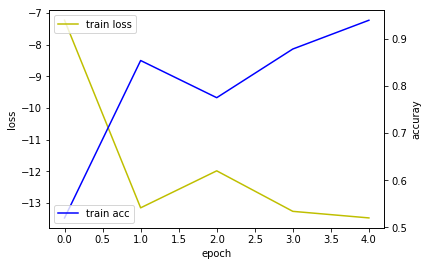

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [10]:
# # 모델 평가하기
# loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
# print('')
# print('loss_and_metrics : ' + str(loss_and_metrics))
# 모델 평가하기
scores = model.evaluate(x_test, y_test)
print("%s: %.2f%%" %(model.metrics_names[0], scores[1]*100))
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

56962/56962 [==============================] - 1s 20us/step
loss: 99.62%
acc: 99.62%


In [11]:
#true positives, false negative 구하기

#true만 추출
df_positive = df_norm_test[df_norm_test.Class!=0.0]

# round predictions
prediction_positive = model.predict(df_positive.loc[:,'V1':'Amount'])
rounded_positive = [round(x[0]) for x in prediction_positive]

#true positives
tp = rounded_positive.count(1.0)
#false negative
fn = rounded_positive.count(0.0)
print("tp : ",tp)
print("fn : ",fn)
print("positive : ", len(df_positive))

tp :  61
fn :  14
positive :  75


In [12]:
#false positive, true negative 구하기

#false만 추출
df_negative = df_norm_test[df_norm_test.Class==0.0]

# round predictions
prediction_negative = model.predict(df_negative.loc[:,'V1':'Amount'])
rounded_negative = [round(x[0]) for x in prediction_negative]

#false positive
fp = rounded_negative.count(1.0)
#true negative
tn = rounded_negative.count(0.0)
print("fp : ",fp)
print("tn : ",tn)
print("negative : ", len(df_negative))

fp :  141
tn :  56746
negative :  56887


In [13]:
# http://bcho.tistory.com/1206 참고
# recall(민감도) 측정
recall = tp/(tp+fn)
print("recall = tp/(tp+fn) : ", recall)

#precision(정밀성) 측정
precision = tp/(tp+fp)
print("precision = tp/(tp+fp) : ", precision)

#accuracy(정확도) 측정
accuracy = (tp+tn)/(len(df_negative) + len(df_positive))
print("accuracy = (tp+tn)/(len(df_negative) + len(df_positive)) : ", accuracy)

#f1 score
f1_score = (2*precision*recall)/(precision+recall)
print("f1 score = (2*precision*recall)/(precision+recall) : ", f1_score)

recall = tp/(tp+fn) :  0.8133333333333334
precision = tp/(tp+fp) :  0.30198019801980197
accuracy = (tp+tn)/(len(df_negative) + len(df_positive)) :  0.9972788876795057
f1 score = (2*precision*recall)/(precision+recall) :  0.4404332129963899
